# Create Submission From Model

Run inference on the test images to create results ready for submission. This will create a folder called `submission` in the current directory.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, torchvision
torch.__version__

'1.3.0'

In [3]:
from detectron2.evaluation.xview_evaluation import *

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import os
import numpy as np
import json
import shutil
import cv2
import random
import glob

import matplotlib.pyplot as plt
%matplotlib inline

/home/ethanweber/anaconda3/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [5]:
# Set some parameters.
LOCALIZATION_SUBMISSION_FOLDER = "SUBMISSION_LOCALIZATION"
LOCALIZATION_MODEL_CONFIG = "./detectron2_repo/configs/xview/mask_rcnn_R_50_FPN_1x-localization.yaml"
DAMAGE_SUBMISSION_FOLDER = "SUBMISSION_DAMAGE"
DAMAGE_MODEL_CONFIG = "./detectron2_repo/configs/xview/mask_rcnn_R_50_FPN_1x-damage.yaml"

In [6]:
# Removes and creates folders (clears them).
shutil.rmtree(LOCALIZATION_SUBMISSION_FOLDER, ignore_errors=True)
shutil.rmtree(DAMAGE_SUBMISSION_FOLDER, ignore_errors=True)
os.mkdir(LOCALIZATION_SUBMISSION_FOLDER)
os.mkdir(DAMAGE_SUBMISSION_FOLDER)

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# Load localization model.
# cfg_localization = get_cfg()
# cfg_localization.merge_from_file(LOCALIZATION_MODEL_CONFIG)
# # Load localization checkpoint.
# cfg_localization.MODEL.WEIGHTS = os.path.join(cfg_localization.OUTPUT_DIR, "model_0054999.pth")
# cfg_localization.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model
# predictor_localization = DefaultPredictor(cfg_localization)

# Load damage model.
cfg_damage = get_cfg()
cfg_damage.merge_from_file(DAMAGE_MODEL_CONFIG)
# Load damage checkpoint.
cfg_damage.MODEL.WEIGHTS = os.path.join(cfg_damage.OUTPUT_DIR, "model_0004999.pth")
cfg_damage.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model
predictor_damage = DefaultPredictor(cfg_damage)

WARNING [12/15 22:19:03 d2.config.compat]: Config './detectron2_repo/configs/xview/mask_rcnn_R_50_FPN_1x-damage.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [8]:
image_filenames = sorted(glob.glob("data/test/images/*"))
for filename in image_filenames:
    # Load the image.
    image = cv2.imread(filename)
    
    # Choose the model type based on pre or post localization
    if filename.find("pre") >= 0:
        # LOCALIZATION model.
#         outputs = predictor_localization(image)
    
#         # get to the right format
#         instances = outputs["instances"].to('cpu')
#         # use RLE to encode the masks, because they are too large and takes memory
#         # since this evaluator stores outputs of the entire dataset
#         # Our model may predict bool array, but cocoapi expects uint8
#         rles = [
#             mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
#             for mask in instances.pred_masks
#         ]
#         for rle in rles:
#             # "counts" is an array encoded by mask_util as a byte-stream. Python3's
#             # json writer which always produces strings cannot serialize a bytestream
#             # unless you decode it. Thankfully, utf-8 works out (which is also what
#             # the pycocotools/_mask.pyx does).
#             rle["counts"] = rle["counts"].decode("utf-8")
#         instances.pred_masks_rle = rles
#         instances.remove("pred_masks")
#         prediction = {}
#         prediction["instances"] = instances_to_json(instances)
#         height = 1024
#         width = 1024
        
#         pred_image = get_xview_localization_pred_image(height, width, prediction)
        
        name = os.path.basename(filename)
        new_filename = name.replace("pre", "localization")[:-4] + "_prediction.png"
        submission_filename = os.path.join(LOCALIZATION_SUBMISSION_FOLDER, new_filename)
        print(submission_filename)
        pred_image = np.zeros((1024, 1024))
        cv2.imwrite(submission_filename, pred_image)
        
#     elif filename.find("post") >= 0:
#         # DAMAGE model.
#         outputs = predictor_damage(image)
    
#         # get to the right format
#         instances = outputs["instances"].to('cpu')
#         # use RLE to encode the masks, because they are too large and takes memory
#         # since this evaluator stores outputs of the entire dataset
#         # Our model may predict bool array, but cocoapi expects uint8
#         rles = [
#             mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
#             for mask in instances.pred_masks
#         ]
#         for rle in rles:
#             # "counts" is an array encoded by mask_util as a byte-stream. Python3's
#             # json writer which always produces strings cannot serialize a bytestream
#             # unless you decode it. Thankfully, utf-8 works out (which is also what
#             # the pycocotools/_mask.pyx does).
#             rle["counts"] = rle["counts"].decode("utf-8")
#         instances.pred_masks_rle = rles
#         instances.remove("pred_masks")
#         prediction = {}
#         prediction["instances"] = instances_to_json(instances)
#         height = 1024
#         width = 1024
        
#         pred_image = get_xview_damage_pred_image(height, width, prediction)
        
#         name = os.path.basename(filename)
#         new_filename = name.replace("post", "damage")[:-4] + "_prediction.png"
#         submission_filename = os.path.join(DAMAGE_SUBMISSION_FOLDER, new_filename)
        
#         print(submission_filename)
#         cv2.imwrite(submission_filename, pred_image)

SUBMISSION_LOCALIZATION/test_localization_00000_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00001_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00002_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00003_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00004_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00005_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00006_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00007_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00008_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00009_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00010_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00011_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00012_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00013_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00014_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00015_predict

SUBMISSION_LOCALIZATION/test_localization_00135_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00136_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00137_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00138_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00139_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00140_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00141_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00142_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00143_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00144_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00145_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00146_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00147_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00148_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00149_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00150_predict

SUBMISSION_LOCALIZATION/test_localization_00272_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00273_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00274_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00275_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00276_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00277_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00278_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00279_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00280_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00281_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00282_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00283_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00284_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00285_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00286_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00287_predict

SUBMISSION_LOCALIZATION/test_localization_00409_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00410_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00411_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00412_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00413_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00414_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00415_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00416_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00417_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00418_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00419_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00420_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00421_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00422_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00423_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00424_predict

SUBMISSION_LOCALIZATION/test_localization_00549_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00550_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00551_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00552_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00553_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00554_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00555_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00556_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00557_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00558_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00559_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00560_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00561_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00562_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00563_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00564_predict

SUBMISSION_LOCALIZATION/test_localization_00687_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00688_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00689_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00690_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00691_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00692_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00693_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00694_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00695_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00696_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00697_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00698_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00699_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00700_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00701_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00702_predict

SUBMISSION_LOCALIZATION/test_localization_00823_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00824_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00825_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00826_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00827_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00828_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00829_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00830_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00831_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00832_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00833_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00834_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00835_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00836_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00837_prediction.png
SUBMISSION_LOCALIZATION/test_localization_00838_predict

In [9]:
i = cv2.imread("data/test/images/test_pre_00000.png")

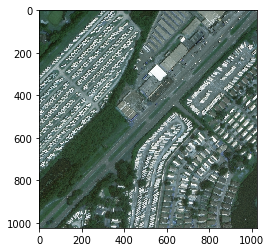

In [10]:
plt.imshow(i)

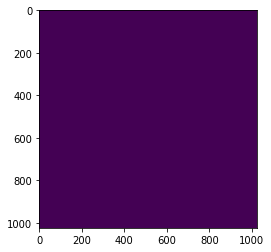

In [11]:
plt.imshow(pred_image)